# CRAG: Corrective RAG

이번 튜토리얼은 **Corrective RAG (CRAG)** 전략을 사용하여 RAG 기반 시스템을 개선하는 방법을 다룹니다. 

CRAG는 검색된 문서들에 대한 자기 반성(self-reflection) 및 자기 평가(self-evaluation) 단계를 포함하여, 검색-생성 파이프라인을 정교하게 다루는 접근법입니다.

![crag](./assets/langgraph-crag.png)

---

**CRAG 란?**

**Corrective-RAG (CRAG)** 는 RAG(Retrieval Augmented Generation) 전략에서 **검색 과정에서 찾아온 문서를 평가하고, 지식을 정제(refine) 하는 단계를 추가한 방법론**입니다. 이는 생성에 앞서 검색 결과를 점검하고 필요하다면 보조적인 검색을 수행하며, 최종적으로 품질 높은 답변을 생성하기 위한 일련의 프로세스를 포함합니다.

CRAG의 핵심 아이디어는 다음과 같습니다. 

[논문(Corrective Retrieval Augmented Generation) 링크](https://arxiv.org/pdf/2401.15884.pdf)

1. 검색된 문서 중 하나 이상이 사전 정의된 관련성 임계값(retrieval validation score) 을 초과하면 생성 단계로 진행합니다.
2. 생성 전에 지식 정제 단계를 수행합니다.
3. 문서를 "knowledge strips" 로 세분화합니다. (여기서, 문서 검색 결과수, `k` 를 의미합니다.)
4. 각 지식 스트립을 평가하고 관련성 여부를 score 로 평가합니다. (여기서는 문서 chunk 단위로 평가합니다.)
5. 모든 문서가 관련성 임계값 이하이거나 평가 결과 신뢰도가 낮을 경우, 추가 데이터 소스(예: 웹 검색)로 보강합니다.
6. 웹 검색을 통한 보강 시, 쿼리 재작성(Query-Rewrite) 을 통해 검색 결과를 최적화합니다.

---

**주요 내용**

이 튜토리얼에서는 LangGraph를 활용하여 CRAG 접근법의 일부 아이디어를 구현합니다.

여기서는 **지식 정제 단계는 생략**하고, 필요하다면 노드로 추가할 수 있는 형태로 설계합니다.  

또한, **관련 있는 문서가 하나도 없으면** 웹 검색을 활용하여 검색을 보완할 것입니다. 

웹 검색에는 [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search/)를 사용하고, 검색 최적화를 위해 질문 재작성(Question Re-writing) 을 도입합니다.

---

**주요 단계 개요**

- **Retrieval Grader**: 검색된 문서의 관련성을 평가
- **Generate**: LLM을 통한 답변 생성
- **Question Re-writer**: 질문 재작성을 통한 검색 질의 최적화
- **Web Search Tool**: Tavily Search를 통한 웹 검색 활용
- **Create Graph**: LangGraph를 통한 CRAG 전략 그래프 생성
- **Use the graph**: 생성된 그래프를 활용하는 방법

---

**참고**

- [LangGraph CRAG 튜토리얼 (공식 문서)](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag_local/)

## 환경 설정



In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retriever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

**참고**

- 이전 튜토리얼에서 다룬 내용이므로, 자세한 설명은 생략합니다.


In [3]:
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

loader = PDFPlumberLoader("data/2024_프로야구_리그규정_요약.pdf")
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = loader.load()
split_docs = text_splitter.split_documents(docs)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = Chroma.from_documents(documents=split_docs, embedding=embeddings)

pdf_retriever = vector_store.as_retriever()

## 검색된 문서의 관련성 평가 (Question-Retrieval Evaluation)

검색된 문서의 관련성 평가는 검색된 문서가 질문과 관련이 있는지 여부를 평가하는 단계입니다.

먼저, 검색된 문서를 평가하기 위한 평가기(`retrieval-grader`) 를 생성합니다.

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs
from pydantic import BaseModel, Field

# 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4)


# 검색된 문서의 관련성 여부를 이진 점수로 평가하는 데이터 모델
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved document."""

    # 문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# GradeDocuments 데이터 모델을 사용하여 구조화된 출력을 생성하는 LLM
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 채팅 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Retrieval 평가기 초기화
retrieval_grader = grade_prompt | structured_llm_grader

`retrieval_grader` 를 사용해서 문서를 평가합니다. 

여기서는 문서의 집합이 아닌 1개의 단일 문서에 대한 평가를 수행합니다.

결과는 단일 문서에 대한 관련성 여부가 (yes/no) 로 반환됩니다.

In [5]:
# 질문 정의
question = "야구는 몇회까지 해?"

# 문서 검색
docs = pdf_retriever.invoke(question)

# 검색된 문서 중 1번 index 문서의 페이지 내용을 추출
doc_txt = docs[1].page_content

# 검색된 문서와 질문을 사용하여 관련성 평가를 실행하고 결과 출력
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


## 답변 생성 체인

답변 생성 체인은 검색된 문서를 기반으로 답변을 생성하는 체인입니다.

우리가 알고 있는 일반적인 Naive RAG 체인 입니다.

In [6]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI


# LangChain Hub에서 RAG 프롬프트를 가져와 사용
prompt = hub.pull("teddynote/rag-prompt")

# LLM 초기화
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)


# 문서 포맷팅
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# 체인 생성
rag_chain = prompt | llm | StrOutputParser()


# 체인 실행 및 결과 출력
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

야구는 9회까지 진행됩니다.

**Source**
- data/2024_프로야구_리그규정_요약.pdf (page 15)


## 쿼리 재작성(Question Re-writer)

쿼리 재작성은 웹 검색을 최적화하기 위해 질문을 재작성하는 단계입니다.

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LLM 설정
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Query Rewrite 시스템 프롬프트
system = """You a question re-writer that converts an input question to a better version that is optimized 
for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

# 프롬프트 정의
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Question Re-writer 체인 초기화
question_rewriter = re_write_prompt | llm | StrOutputParser()

`question_rewriter` 를 사용해서 질문을 재작성합니다.

In [8]:
# 실행 및 결과 확인
print(f'[원본 질문]: "{question}"')
print("[쿼리 재작성]:", question_rewriter.invoke({"question": question}))

[원본 질문]: "야구는 몇회까지 해?"
[쿼리 재작성]: 야구 경기는 총 몇 회로 진행되나요?


## 웹 검색 도구

**웹 검색 도구**는 컨텍스트를 보강하기 위한 용도로 사용됩니다.

- **웹 검색의 필요성**: 모든 문서가 관련성 임계값을 충족하지 않거나 평가자가 확신이 없을 때, 웹 검색을 통해 추가 데이터를 확보합니다.
- **Tavily Search 사용**: Tavily Search를 활용하여 웹 검색을 수행합니다. 이는 검색 쿼리를 최적화하고, 보다 관련성 높은 결과를 제공합니다.
- **질문 재작성**: 웹 검색을 최적화하기 위해 질문을 재작성하여 검색 쿼리를 개선합니다.

In [9]:
# 웹 검색 도구 초기화
from langchain_teddynote.tools.tavily import TavilySearch

# 최대 검색 결과를 3으로 설정
web_search_tool = TavilySearch(max_results=3)

In [ ]:
# 웹 검색 도구 실행
results = web_search_tool.invoke({"query": question})
print(results)

## 상태(State)

먼저, CRAG 그래프를 위한 상태를 정의합니다.

`web_search` 는 웹 검색을 활용할지 여부를 나타내는 상태입니다. yes 또는 no 로 표현합니다 (yes: 웹 검색 필요, no: 필요 없음)

In [10]:
from typing import Annotated, List
from typing_extensions import TypedDict


# 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "The question to answer"]
    generation: Annotated[str, "The generation from the LLM"]
    web_search: Annotated[str, "Whether to add search"]
    documents: Annotated[List[str], "The documents retrieved"]

## 노드

CRAG 그래프에 활용할 노드를 정의합니다.

In [11]:
from langchain.schema import Document


# 문서 검색 노드
def retrieve(state: GraphState):
    print("\n==== RETRIEVE ====\n")
    question = state["question"]

    # 문서 검색 수행
    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# 답변 생성 노드
def generate(state: GraphState):
    print("\n==== GENERATE ====\n")
    question = state["question"]
    documents = state["documents"]

    # RAG를 사용한 답변 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# 문서 평가 노드
def grade_documents(state: GraphState):
    print("\n==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====\n")
    question = state["question"]
    documents = state["documents"]

    # 필터링된 문서
    filtered_docs = []
    relevant_doc_count = 0

    for d in documents:
        # Question-Document 의 관련성 평가
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score

        if grade == "yes":
            print("==== [GRADE: DOCUMENT RELEVANT] ====")
            # 관련 있는 문서를 filtered_docs 에 추가
            filtered_docs.append(d)
            relevant_doc_count += 1
        else:
            print("==== [GRADE: DOCUMENT NOT RELEVANT] ====")
            continue

    # 관련 문서가 없으면 웹 검색 수행
    web_search = "Yes" if relevant_doc_count == 0 else "No"
    return {"documents": filtered_docs, "web_search": web_search}


# 쿼리 재작성 노드
def query_rewrite(state: GraphState):
    print("\n==== [REWRITE QUERY] ====\n")
    question = state["question"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}


# 웹 검색 노드
def web_search(state: GraphState):
    print("\n==== [WEB SEARCH] ====\n")
    question = state["question"]
    documents = state["documents"]

    # 웹 검색 수행
    docs = web_search_tool.invoke({"query": question})
    # 검색 결과를 문서 형식으로 변환
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents}

## 조건부 엣지에 활용할 함수

`decide_to_generate` 함수는 관련성 평가를 마친 뒤, 웹 검색 여부에 따라 다음 노드로 라우팅하는 역할을 수행합니다.

`web_search` 가 `Yes` 인 경우 `query_rewrite` 노드에서 쿼리를 재작성 한 뒤 웹 검색을 수행합니다.

만약, `web_search` 가 `No` 인 경우는 `generate` 를 수행하여 최종 답변을 생성합니다.

In [12]:
def decide_to_generate(state: GraphState):
    # 평가된 문서를 기반으로 다음 단계 결정
    print("==== [ASSESS GRADED DOCUMENTS] ====")
    # 웹 검색 필요 여부
    web_search = state["web_search"]

    if web_search == "Yes":
        # 웹 검색으로 정보 보강이 필요한 경우
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ===="
        )
        # 쿼리 재작성 노드로 라우팅
        return "query_rewrite"
    else:
        # 관련 문서가 존재하므로 답변 생성 단계(generate) 로 진행
        print("==== [DECISION: GENERATE] ====")
        return "generate"

## 그래프 생성

이제 노드를 정의하고 엣지를 연결하여 그래프를 완성합니다.

In [13]:
from langgraph.graph import END, StateGraph, START

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("web_search_node", web_search)

# 엣지 연결
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# 문서 평가 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "query_rewrite": "query_rewrite",
        "generate": "generate",
    },
)

# 엣지 연결
workflow.add_edge("query_rewrite", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# 그래프 컴파일
app = workflow.compile()

그래프를 시각화합니다.

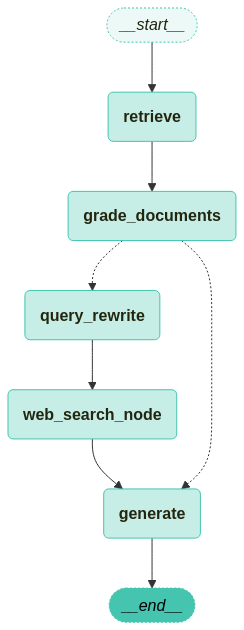

In [14]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

이제 그래프를 실행하고 결과를 확인합니다.

In [15]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "야구는 몇회까지 해?",
}

# 스트리밍 형식으로 그래프 실행
stream_graph(
    app,
    inputs,
    config,
    ["retrieve", "grade_documents", "query_rewrite", "web_search_node", "generate"],
)


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ====

==== [REWRITE QUERY] ====


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
야구 경기는 총 몇 회로 진행되나요?
==== [WEB SEARCH] ====


==== GENERATE ====


🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
야구 경기는 기본적으로 9회로 진행됩니다. 그러나 9회가 끝난 후에도 승부가 나지 않으면 연장전이 진행됩니다.

**Source**
- Document (page_content)

In [16]:
# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "2024년 노벨문학상 수상자의 이름은?",
}

그래프를 실행합니다.

In [17]:
# 그래프 실행
invoke_graph(app, inputs, config)


==== RETRIEVE ====


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='당해 시즌에 현역선수로 1일 이상 등록한 부상선수에 한해 시즌
최대 30일까지 가능하며(10일 3회, 15일 2회, 30일 1회에 한함)
선수의 엔트리 말소일부터 3일 이내에 신청서 및 구단 지정 병
원에서 발급한 진단서를 제출해야 한다(3일 소급 적용).
선수의 부상 경과를 지켜본 이후 부상자 명단 등재 여부를 결
정할 수 있도록 엔트리 말소를 유예할 수 있다. 유예는 별도의
절차 없이 선수의 마지막 경기 출장 다음 날로부터 최대 3일까
지 인정되며, 유예 인정 기간 다음 날까지 엔트리 말소 및 이후
부상자 명단에 등록된 경우 선수의 엔트리 말소일 및 부상자
명단 등록 시작일은 신청서에 작성한 유예 인정 기간 내의 등
재 시작일까지 소급 적용될 수 있다.
부상자 명단에 등재되어 있는 선수가 동일한 부상을 사유로 연
장 신청할 경우에는 추가 진단서 없이 신청서 제출만으로 연장
가능하다. 단, 1회에 한하며, 연장 신청 기간이 기존 진단서 내' metadata={'CreationDate': "D:20240403201030-09'00'", 'Creator': 'nPDF (pdftk 1.41)', 'ModDate': 'D:20241228092714Z', 'Producer': '3-Heightsâ—¢ PDF Optimization Shell 6.3.1.5 (http://www.pdf-tools.com)', 'file_path': 'data/2024_프로야구_리그규정_요약.pdf', 'page': 8, 'source': 'data/2024_프로야구_리그규정_요약.pdf', 'total_pages': 18}
page_content='하여 노트북 및 태블릿 PC의 반입 및 KBO에 사전 신고한 유
니폼 내 착용하는 형태의 웨어러블 전자 퍼포먼스 트래킹 시스
템의 착용을 허용하도록 한다.

스트리밍 형식으로 그래프를 실행합니다.

In [ ]:
# 그래프 실행
stream_graph(
    app,
    inputs,
    config,
    ["retrieve", "grade_documents", "query_rewrite", "generate"],
)